# Check GPU Status

In [1]:
# Check GPU status
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Pre-Process Financial News Data from Reuters
The Reuters news comes in TSV files, with separate files for each day (e.g., we have 2,600 days, meaning we have 2,600 TSV files). We need to merge them into one file, clean the data, and drop null values.

In [2]:
import os
import pandas as pd
from datetime import datetime

# Define the folder path
folder_path = "reuters"
output_file = "cleaned_reuters_data.csv"

all_data = pd.DataFrame()

# Loop through each file in the folder
for file in sorted(os.listdir(folder_path)):
    if file.endswith(".tsv"):  # Process only TSV files
        file_path = os.path.join(folder_path, file)

        # Read the TSV file
        data = pd.read_csv(file_path, sep="\t")

        # Keep only the relevant columns
        data = data[['ts', 'title']]

        # Convert 'ts' to datetime format
        data['ts'] = pd.to_datetime(data['ts'], format='%Y%m%d %I:%M%p %Z', errors='coerce')

        # Drop missing timestamps rows
        data = data.dropna(subset=['ts'])

        # Append to the combined Dataframe
        all_data = pd.concat([all_data, data], ignore_index=True)

# Drop duplicate rows based on the 'title' column
all_data = all_data.drop_duplicates(subset=['title'])

# Save the cleaned data to a CSV file
all_data.to_csv(output_file, index=False)

print(f"Data cleaning complete. Cleaned data saved to {output_file}")

FileNotFoundError: [Errno 2] No such file or directory: 'reuters'

In [2]:
import pandas as pd

# Load the cleaned data
cleaned_data_path = "cleaned_reuters_data.csv"
cleaned_data = pd.read_csv(cleaned_data_path)

# Show a sample of the data
cleaned_data.head()

,ts,title
0,2009-11-16 23:58:00+00:00,India Bharti starts operations on consortium c...
1,2009-11-16 23:58:00+00:00,"Hu says U.S., China to deal with North Korea v..."
2,2009-11-16 23:55:00+00:00,"China, US eye banking agreement-paper"
3,2009-11-16 23:49:00+00:00,China's Hu hails frank talks with U.S. Obama
4,2009-11-16 23:48:00+00:00,"Nickelodeon orders ""Summer Camp"" pilot"


In [3]:
cleaned_data.shape

(4912416, 2)

In [4]:
# Check total rows 
print(f"Total rows in original dataset: {len(cleaned_data)}")

# Check rows with non-NaN titles
valid_titles = cleaned_data['title'].notna().sum()
print(f"Rows with valid titles: {valid_titles}")

Total rows in original dataset: 4912416
Rows with valid titles: 4912415


# Addition news headline from another sources
We can also find another dataset that combines news from The Guardian, Reuters, and CNBC from 2018 to 2020. We want to use this dataset as well. To do so, we will clean the data and align the column names to match the previous news dataset. Finally, we can merge them into a single file.

In [5]:
import pandas as pd

# Load the cleaned data
addnews_data_path = "additional_news.csv"
addnews_data = pd.read_csv(addnews_data_path)

# Show a sample of the data
addnews_data.head()

,Headlines,Time,Sentiment
0,Jim Cramer: A better way to invest in the Covi...,2020-07-17,positive
1,Cramer's lightning round: I would own Teradyne,2020-07-17,negative
2,"Cramer's week ahead: Big week for earnings, ev...",2020-07-17,positive
3,IQ Capital CEO Keith Bliss says tech and healt...,2020-07-17,positive
4,Wall Street delivered the 'kind of pullback I'...,2020-07-16,negative


In [6]:
print(addnews_data['Sentiment'].unique())

['positive' 'negative' 'neutral']


In [7]:
# Convert "Time" column in datetime format
addnews_data['Time'] = pd.to_datetime(addnews_data['Time']).dt.strftime('%Y-%m-%d %H:%M:%S+00:00')

# Map "sentiment" column values to 1, 0, and 2 (like above)
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': 2}
addnews_data['Sentiment'] = addnews_data['Sentiment'].map(sentiment_mapping)

# Rename columns to be aligned with above news data 
addnews_data.rename(columns={'Time': 'ts', 'Headlines': 'title', 'Sentiment': 'sentiment'}, inplace=True)

# Reorder columns to make 'ts' the first column to aligned it with the above news data
addnews_data = addnews_data[['ts', 'title', 'sentiment']]

addnews_data.head()

,ts,title,sentiment
0,2020-07-17 00:00:00+00:00,Jim Cramer: A better way to invest in the Covi...,1
1,2020-07-17 00:00:00+00:00,Cramer's lightning round: I would own Teradyne,2
2,2020-07-17 00:00:00+00:00,"Cramer's week ahead: Big week for earnings, ev...",1
3,2020-07-17 00:00:00+00:00,IQ Capital CEO Keith Bliss says tech and healt...,1
4,2020-07-16 00:00:00+00:00,Wall Street delivered the 'kind of pullback I'...,2


In [8]:
# Save the updated file
addnews_data.to_csv("cleaned_additional_news.csv", index=False)

In [9]:
addnews_data.shape

(35570, 3)

In [10]:
print(addnews_data.isnull().sum())

ts           0
title        0
sentiment    0
dtype: int64


# Add Sentimental label to Reuters from FinBERT
The Reuters news does not come with sentiment labels (neutral, negative, positive), so we will use FinBERT, a pre-trained NLP model, to add sentiment labels to the news headlines. The model assigns sentiment as follows: 0 = neutral, 1 = positive, and 2 = negative.

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load data
cleaned_data_path = "cleaned_reuters_data.csv"
cleaned_data = pd.read_csv(cleaned_data_path)

# Ensure titles are valid
cleaned_data = cleaned_data[cleaned_data['title'].notnull()]  # Remove null rows 
titles = cleaned_data['title'].astype(str).tolist()

# Load FinBERT model & tokenizer
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Enable GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to GPU

# Classify entiment in batches
def classify_sentiment_batch(texts):
    try:
        inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        with torch.no_grad(): 
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            sentiments = torch.argmax(probs, dim=-1).tolist()  # 0: Neutral, 1: Positive, 2: Negative
        return sentiments
    except Exception as e:
        print(f"Error in batch processing: {e}")
        return [None] * len(texts) 

# Process data in batches
batch_size = 32  
sentiments = []
retry_limit = 3  

print("Starting sentiment analysis...")
for i in range(0, len(titles), batch_size):
    batch = titles[i:i + batch_size]
    for attempt in range(retry_limit):
        batch_sentiments = classify_sentiment_batch(batch)
        if all(s is not None for s in batch_sentiments):
            sentiments.extend(batch_sentiments)
            break  
        elif attempt == retry_limit - 1:  
            print(f"Failed to process batch {i} to {i + batch_size} after {retry_limit} attempts.")
            sentiments.extend([None] * len(batch))  
    # Print progress
    if (i // batch_size) % 10 == 0: 
        print(f"Processed {i} titles out of {len(titles)}")

# Add sentiment labels to the Dataframe
cleaned_data = cleaned_data.iloc[:len(sentiments)]  
cleaned_data['sentiment'] = sentiments

# Check & report missing values
null_sentiment_count = cleaned_data['sentiment'].isnull().sum()
if null_sentiment_count > 0:
    print(f"Warning: {null_sentiment_count} rows have null sentiment values.")

# Save the data
labeled_data_path = "labeled_reuters_data_fixed.csv"
cleaned_data.to_csv(labeled_data_path, index=False)

print(f"Sentiment labels added. Labeled data saved to {labeled_data_path}")

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Streaming output truncated to the last 5000 lines.
Processed 3312960 titles out of 4912415
Processed 3313280 titles out of 4912415
Processed 3313600 titles out of 4912415
Processed 3313920 titles out of 4912415
Processed 3314240 titles out of 4912415
Processed 3314560 titles out of 4912415
Processed 3314880 titles out of 4912415
Processed 3315200 titles out of 4912415
Processed 3315520 titles out of 4912415
Processed 3315840 titles out of 4912415
Processed 3316160 titles out of 4912415
Processed 3316480 titles out of 4912415
Processed 3316800 titles out of 4912415
Processed 3317120 titles out of 4912415
Processed 3317440 titles out of 4912415
Processed 3317760 titles out of 4912415
Processed 3318080 titles out of 4912415
Processed 3318400 titles out of 4912415
Processed 3318720 titles out of 4912415
Processed 3319040 titles out of 4912415
Processed 3319360 titles out of 4912415
Processed 3319680 titles out of 4912415
Processed 3320000 titles out of 4912415
Processed 3320320 titles out 

In [11]:
import pandas as pd

# Load the labeled data
labeled_data_path = "labeled_reuters_data_fixed.csv"
labeled_data = pd.read_csv(labeled_data_path)

# Show sample rows of the data
labeled_data.head()

,ts,title,sentiment
0,2009-11-16 23:58:00+00:00,India Bharti starts operations on consortium c...,0
1,2009-11-16 23:58:00+00:00,"Hu says U.S., China to deal with North Korea v...",0
2,2009-11-16 23:55:00+00:00,"China, US eye banking agreement-paper",0
3,2009-11-16 23:49:00+00:00,China's Hu hails frank talks with U.S. Obama,0
4,2009-11-16 23:48:00+00:00,"Nickelodeon orders ""Summer Camp"" pilot",0


In [12]:
labeled_data.shape

(4912415, 3)

In [13]:
# Count the number of each sentiment
sentiment_counts = labeled_data['sentiment'].value_counts()

# Print the count
print("Sentiment Counts:")
print(sentiment_counts)

Sentiment Counts:
sentiment
0    3731485
1     778383
2     402547
Name: count, dtype: int64


In [14]:
print(labeled_data.isnull().sum())

ts           0
title        0
sentiment    0
dtype: int64


Merge all financial news data (Finbert & Additional news)

In [15]:
# Inspect the column
print(addnews_data.columns)
print(labeled_data.columns)

Index(['ts', 'title', 'sentiment'], dtype='object')
Index(['ts', 'title', 'sentiment'], dtype='object')


In [16]:
# Check for sentiment column
print('sentiment' in addnews_data.columns)
print('sentiment' in labeled_data.columns)

True
True


In [17]:
# Check null values before merging
print(addnews_data['sentiment'].isnull().sum())
print(labeled_data['sentiment'].isnull().sum())

0
0


# Merge financial news data

In [18]:
# Load the 2 cleaned datasets 
cleaned_additional_news = pd.read_csv("cleaned_additional_news.csv")
cleaned_reuters_data = pd.read_csv("labeled_reuters_data_fixed.csv")

# Merge data
merged_data = pd.concat([cleaned_additional_news, cleaned_reuters_data], ignore_index=True)

# Replace sentiment labels: Negative (2) to -1 (because it makes more sense)
merged_data['sentiment'] = merged_data['sentiment'].replace({2: -1})

# Save data
merged_data.to_csv("merged_news_data.csv", index=False)

print("Merged and updated dataset saved to 'merged_news_data.csv'")

Merged and updated dataset saved to 'merged_news_data.csv'


In [19]:
merged_data.head()

,ts,title,sentiment
0,2020-07-17 00:00:00+00:00,Jim Cramer: A better way to invest in the Covi...,1
1,2020-07-17 00:00:00+00:00,Cramer's lightning round: I would own Teradyne,-1
2,2020-07-17 00:00:00+00:00,"Cramer's week ahead: Big week for earnings, ev...",1
3,2020-07-17 00:00:00+00:00,IQ Capital CEO Keith Bliss says tech and healt...,1
4,2020-07-16 00:00:00+00:00,Wall Street delivered the 'kind of pullback I'...,-1


In [20]:
merged_data.shape

(4947985, 3)

In [21]:
print(f"Merged news date range: {merged_data['ts'].min()} to {merged_data['ts'].max()}")

Merged news date range: 2009-11-16 00:00:00+00:00 to 2020-07-18 00:00:00+00:00


In [22]:
print(merged_data['sentiment'].value_counts())

sentiment
 0    3737605
 1     794631
-1     415749
Name: count, dtype: int64


In [23]:
print(merged_data.isnull().sum())

ts           0
title        0
sentiment    0
dtype: int64


# Select only news related to AAPL (Apple Company)
We will use the BERT Sentence Transformer to filter news related to Apple, as we have decided to focus on one company for this project, and we have chosen Apple (AAPL).

In [24]:
pip install sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [25]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import torch

# Load data set in chunk because it's a lot of data
chunk_size = 100000  
merged_news_data_path = "merged_news_data.csv"

# Load  Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Define Apple-related keywords 
keywords = [
    'Apple',
    'iPhone',
    'MacBook',
    'iPad',
    'Apple revenue',
    'Apple earnings',
    'Apple product',
    'Apple stock',
    'smartphone',
    'mobile phone',
    'laptop',
    'computer',
    'samsung',
    'phone',
    'mobile',
    'Nokia',
    'gadget',
    'ios',
    'technology'
]

# Create a regex to ensure exact matches
keywords_regex = r'\b(?:' + '|'.join(keywords) + r')\b'

filtered_rows = []

# Process the dataset 
for chunk in pd.read_csv(merged_news_data_path, chunksize=chunk_size):
    # Pre-filter using keywords with exact matches
    keyword_filtered = chunk[chunk['title'].str.contains(keywords_regex, case=False, na=False, regex=True)]

    # Generate embeddings for the filtered titles
    titles = keyword_filtered['title'].dropna().tolist()
    embeddings = model.encode(titles, convert_to_tensor=True)

    # Generate embeddings for the queries
    query_embeddings = model.encode(keywords, convert_to_tensor=True)

    # Compute cosine similarities & take max score for each title
    cosine_scores = torch.max(util.cos_sim(query_embeddings, embeddings), dim=0)[0]

    # Filter by similarity threshold
    threshold = 0.2
    indices = [i for i, score in enumerate(cosine_scores) if score > threshold]

    # Append matching rows to the filtered list
    filtered_rows.append(keyword_filtered.iloc[indices])

# Combine all filtered rows into a 1 Dataframe
filtered_data = pd.concat(filtered_rows, ignore_index=True)

# Save data
filtered_data.to_csv("filtered_apple_news.csv", index=False)
print(f"Filtered dataset saved with {len(filtered_data)} rows.")

Filtered dataset saved with 145743 rows.


In [26]:
# Show a sample of the filtered data
filtered_data.head()

,ts,title,sentiment
0,2020-06-30 00:00:00+00:00,Cramer's lightning round: Nokia has 'good thin...,-1
1,2020-06-25 00:00:00+00:00,Marc Benioff says 35 states are now using Sale...,-1
2,2020-04-23 00:00:00+00:00,Cramer's lightning round: Marvell Technology i...,-1
3,2020-03-03 00:00:00+00:00,Charts show the S&P's bounce may be 'ephemeral...,1
4,2020-02-19 00:00:00+00:00,"Everything Jim Cramer said on 'Mad Money,' inc...",1


In [27]:
print(f"Merged news date range: {filtered_data['ts'].min()} to {filtered_data['ts'].max()}")

Merged news date range: 2009-11-16 00:00:00+00:00 to 2020-07-16 00:00:00+00:00


In [28]:
filtered_data.shape

(145743, 3)

In [29]:
# Check unique day
filtered_data['ts'] = pd.to_datetime(filtered_data['ts'])

filtered_data['date_only'] = filtered_data['ts'].dt.date

unique_dates_count = filtered_data['date_only'].nunique()

print(f"Number of unique dates in filtered_data: {unique_dates_count}")

Number of unique dates in filtered_data: 2831


In [30]:
# Just checking by filter rows for the specific date (2009-11-16)
specific_date_news = filtered_data[filtered_data['ts'].dt.date == pd.to_datetime("2009-11-16").date()]

# Display all rows for the specific date
print(specific_date_news)

                            ts  \
1130 2009-11-16 21:45:00+00:00   
1131 2009-11-16 21:05:00+00:00   
1132 2009-11-16 20:00:00+00:00   
1133 2009-11-16 19:51:00+00:00   
1134 2009-11-16 18:44:00+00:00   
...                        ...   
1243 2009-11-16 02:00:00+00:00   
1244 2009-11-16 01:52:00+00:00   
1245 2009-11-16 01:00:00+00:00   
1246 2009-11-16 00:09:00+00:00   
1247 2009-11-16 00:00:00+00:00   

                                                  title  sentiment   date_only  
1130  Volvo keeps rights to technology in Geely plan...          0  2009-11-16  
1131  Convey Computer Corporation Honored with HPCwi...          1  2009-11-16  
1132  GSMA Shines Spotlight on Asian Mobile Industry...          0  2009-11-16  
1133          Does It Make Sense for Nokia to Buy Palm?          0  2009-11-16  
1134  Immersion Presenting at Mobile User Experience...          0  2009-11-16  
...                                                 ...        ...         ...  
1243  Stratos Expands it

# Fetch Stock Price Data
Then we add stock price (AAPL) from yahoo finance.

In [31]:
pip install yfinance

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [32]:
import yfinance as yf

stock_data = yf.download('AAPL', start='2009-11-15', end='2020-07-17', interval='1d')

stock_data.reset_index(inplace=True)

stock_data_path = "aapl_stock_data.csv"
stock_data.to_csv(stock_data_path, index=False)

print("Stock data saved. Here's a preview:")
stock_data.head()

[*********************100%***********************]  1 of 1 completed

Stock data saved. Here's a preview:


Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
0,2009-11-16 00:00:00+00:00,6.225078,7.379643,7.428571,7.321786,7.338571,485206400
1,2009-11-17 00:00:00+00:00,6.236224,7.392857,7.408571,7.321429,7.360000,396513600
2,2009-11-18 00:00:00+00:00,6.204892,7.355714,7.392857,7.285714,7.376429,374320800
3,2009-11-19 00:00:00+00:00,6.040702,7.161071,7.307500,7.135714,7.307500,542326400
4,2009-11-20 00:00:00+00:00,6.022927,7.140000,7.156786,7.062857,7.112500,406666400


# Align News Sentiment with Stock Prices
We will merge the filtered news data (related to Apple) with stock price data into a single file. Next, we will calculate features such as:

- The average sentiment score for each day (since there may be multiple news articles in a single day).

- The variance of sentiment scores for the day's articles.

- The count of positive and negative news articles for each day.

Additionally, we will create the target variable based on the actual stock closing price as follows:

- 0 (neutral): If today's closing price is the same as yesterday's closing price.

- 1 (positive): If today's closing price is higher than yesterday's closing price.

- 2 (negative): If today's closing price is lower than yesterday's closing price.


In [33]:
import numpy as np
import pandas as pd

# Load filtered news data & stock price data
labeled_data = pd.read_csv("filtered_apple_news.csv")
stock_data = pd.read_csv("aapl_stock_data.csv")

# Convert timestamps to datetime
labeled_data['ts'] = pd.to_datetime(labeled_data['ts'])
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Remove timezone from stock data
stock_data['Date'] = stock_data['Date'].dt.tz_localize(None)

# Extract day from timestamp for grouping
labeled_data['day'] = labeled_data['ts'].dt.date

# Compute daily aggregated sentiment features
daily_sentiment = labeled_data.groupby('day').agg(
    avg_sentiment=('sentiment', 'mean'),  # Avg sentiment
    variance=('sentiment', 'var'),       # Variance of sentiment
    pos_count=('sentiment', lambda x: (x > 0).sum()),  # Positive count
    neg_count=('sentiment', lambda x: (x < 0).sum())   # Negative count
).reset_index()

# Rename & ensure 'Date' is in datetime format
daily_sentiment.rename(columns={'day': 'Date'}, inplace=True)
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])

# Debugging: Check daily sentiment features
print("Daily Sentiment Features:")
print(daily_sentiment.head())

# Align daily sentiment features with stock data
aligned_data = pd.merge(stock_data, daily_sentiment, on='Date', how='left')

# Ensure numeric columns in stock data are properly converted to float
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
aligned_data[numeric_cols] = aligned_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Drop missing rows 
aligned_data.dropna(subset=numeric_cols, inplace=True)

# Fill missing sentiment values with rolling average
aligned_data[['avg_sentiment', 'variance', 'pos_count', 'neg_count']] = aligned_data[[
    'avg_sentiment', 'variance', 'pos_count', 'neg_count']].fillna(
    aligned_data[['avg_sentiment', 'variance', 'pos_count', 'neg_count']].rolling(window=3, min_periods=1).mean()
).fillna(0)  # Fill remaining NaN with 0

# Define thresholds for classifying "Neutral" movement
threshold = 0.01  

# Create the multi-class target variable
aligned_data['target'] = np.where(
    (aligned_data['Close'].shift(-1) - aligned_data['Close']) > threshold,  
    1,  # Class 1: Increase
    np.where(
        (aligned_data['Close'].shift(-1) - aligned_data['Close']) < -threshold,  
        2,  # Class 2: Decrease
        0  # Class 0: Neutral
    )
)

# Drop rows with NaN target (last row won't have a target)
aligned_data = aligned_data.dropna(subset=['target'])
aligned_data['target'] = aligned_data['target'].astype(int)  

# Save data
aligned_data.to_csv("aligned_data_with_features.csv", index=False)

# Debugging & validation
print("Aligned dataset saved with additional features. Here's a preview:")
print(aligned_data[['Date', 'avg_sentiment', 'variance', 'pos_count', 'neg_count', 'target']].head())

# Check class distribution
print("\nClass Distribution in Target Variable:")
print(aligned_data['target'].value_counts())

print("\nAligned Data Shape:", aligned_data.shape)

Daily Sentiment Features:
        Date  avg_sentiment  variance  pos_count  neg_count
0 2009-11-16       0.288136  0.241055         36          2
1 2009-11-17       0.278689  0.219211         35          1
2 2009-11-18       0.206897  0.217691         27          3
3 2009-11-19       0.250000  0.247573         29          3
4 2009-11-20       0.188679  0.271408         13          3
Aligned dataset saved with additional features. Here's a preview:
        Date  avg_sentiment  variance  pos_count  neg_count  target
1 2009-11-16       0.288136  0.241055       36.0        2.0       1
2 2009-11-17       0.278689  0.219211       35.0        1.0       2
3 2009-11-18       0.206897  0.217691       27.0        3.0       2
4 2009-11-19       0.250000  0.247573       29.0        3.0       2
5 2009-11-20       0.188679  0.271408       13.0        3.0       1

Class Distribution in Target Variable:
target
1    1380
2    1219
0      85
Name: count, dtype: int64

Aligned Data Shape: (2684, 12)


In [34]:
aligned_data.head()

,Date,Adj Close,Close,High,Low,Open,Volume,avg_sentiment,variance,pos_count,neg_count,target
1,2009-11-16,6.225078,7.379643,7.428571,7.321786,7.338571,485206400.0,0.288136,0.241055,36.0,2.0,1
2,2009-11-17,6.236224,7.392857,7.408571,7.321429,7.360000,396513600.0,0.278689,0.219211,35.0,1.0,2
3,2009-11-18,6.204892,7.355714,7.392857,7.285714,7.376429,374320800.0,0.206897,0.217691,27.0,3.0,2
4,2009-11-19,6.040702,7.161071,7.307500,7.135714,7.307500,542326400.0,0.250000,0.247573,29.0,3.0,2
5,2009-11-20,6.022927,7.140000,7.156786,7.062857,7.112500,406666400.0,0.188679,0.271408,13.0,3.0,1


In [35]:
print(f"Filtered news date range: {labeled_data['ts'].min()} to {labeled_data['ts'].max()}")
print(f"Stock data date range: {stock_data['Date'].min()} to {stock_data['Date'].max()}")

Filtered news date range: 2009-11-16 00:00:00+00:00 to 2020-07-16 00:00:00+00:00
Stock data date range: 2009-11-16 00:00:00 to 2020-07-16 00:00:00


In [36]:
aligned_data.shape

(2684, 12)

# Split the data
Training Set: 2009-11-16 to 2018-12-01 (~80% of the data)

Validation Set: 2018-12-02 to 2019-09-30 (~10% of the data)

Testing Set: 2019-10-01 to 2020-07-16 (~10% of the data).

In [38]:
import pandas as pd

# Load aligned dataset
aligned_data_path = "aligned_data_with_features.csv"
aligned_data = pd.read_csv(aligned_data_path)

aligned_data['Date'] = pd.to_datetime(aligned_data['Date'])

# Split data chronologically
train_data = aligned_data[aligned_data['Date'] < '2018-12-01']
val_data = aligned_data[(aligned_data['Date'] >= '2018-12-02') & (aligned_data['Date'] < '2019-09-30')]
test_data = aligned_data[aligned_data['Date'] >= '2019-10-01']

print(f"Training set: {len(train_data)} rows")
print(f"Validation set: {len(val_data)} rows")
print(f"Testing set: {len(test_data)} rows")

# Save data
train_data.to_csv("train_data.csv", index=False)
val_data.to_csv("val_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

Training set: 2277 rows
Validation set: 206 rows
Testing set: 200 rows


In [39]:
print("Train data columns:", train_data.columns)
print("Validation data columns:", val_data.columns)
print("Test data columns:", test_data.columns)

Train data columns: Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'avg_sentiment', 'variance', 'pos_count', 'neg_count', 'target'],
      dtype='object')
Validation data columns: Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'avg_sentiment', 'variance', 'pos_count', 'neg_count', 'target'],
      dtype='object')
Test data columns: Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'avg_sentiment', 'variance', 'pos_count', 'neg_count', 'target'],
      dtype='object')


In [40]:
# Count class distribution in train, validation, and test datasets
print("Class distribution in training set:")
print(train_data['target'].value_counts())  

print("\nClass distribution in validation set:")
print(val_data['target'].value_counts())  

print("\nClass distribution in testing set:")
print(test_data['target'].value_counts())  

Class distribution in training set:
target
1    1156
2    1043
0      78
Name: count, dtype: int64

Class distribution in validation set:
target
1    109
2     93
0      4
Name: count, dtype: int64

Class distribution in testing set:
target
1    114
2     83
0      3
Name: count, dtype: int64


# Create Sequences for LSTM

In [41]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Features & target
features = ['avg_sentiment', 'Open', 'High', 'Low', 'Close', 'Volume','variance', 'pos_count', 'neg_count'] 
target = 'target'

# Scale features
scaler = MinMaxScaler()
train_features = scaler.fit_transform(train_data[features])
val_features = scaler.transform(val_data[features])
test_features = scaler.transform(test_data[features])

# Create sequences
def create_sequences(data, labels, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(labels[i + seq_length])
    return np.array(X), np.array(y)

# Sequence length
sequence_length = 20

# Create sequences for training, validation, and testing
X_train, y_train = create_sequences(train_features, train_data[target].values, sequence_length)
X_val, y_val = create_sequences(val_features, val_data[target].values, sequence_length)
X_test, y_test = create_sequences(test_features, test_data[target].values, sequence_length)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

Training set: (2267, 10, 9), (2267,)
Validation set: (196, 10, 9), (196,)
Testing set: (190, 10, 9), (190,)


# LSTM Model

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Define LSTM model
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.3)  # Dropout after LSTM
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use last time step
        return out

# Model parameters
input_size = X_train.shape[2]
hidden_size = 128
num_layers = 1
output_size = 3  # Model Classification: 0, 1, 2

model = StockLSTM(input_size, hidden_size, num_layers, output_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation
epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/100, Training Loss: 61.1143, Validation Loss: 5.4161
Epoch 2/100, Training Loss: 58.1113, Validation Loss: 5.4410
Epoch 3/100, Training Loss: 58.1184, Validation Loss: 5.3994
Epoch 4/100, Training Loss: 58.1667, Validation Loss: 5.3860
Epoch 5/100, Training Loss: 58.1049, Validation Loss: 5.3839
Epoch 6/100, Training Loss: 58.0292, Validation Loss: 5.3815
Epoch 7/100, Training Loss: 57.9646, Validation Loss: 5.4280
Epoch 8/100, Training Loss: 58.1071, Validation Loss: 5.3921
Epoch 9/100, Training Loss: 57.9633, Validation Loss: 5.4023
Epoch 10/100, Training Loss: 57.9238, Validation Loss: 5.4354
Epoch 11/100, Training Loss: 57.8234, Validation Loss: 5.3916
Epoch 12/100, Training Loss: 57.8725, Validation Loss: 5.4150
Epoch 13/100, Training Loss: 57.7881, Validation Loss: 5.5314
Epoch 14/100, Training Loss: 57.9243, Validation Loss: 5.4321
Epoch 15/100, Training Loss: 57.9816, Validation Loss: 5.4148
Epoch 16/100, Training Loss: 57.9291, Validation Loss: 5.3941
Epoch 17/100, Tra

In [45]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate on test data
test_loader = DataLoader(test_dataset, batch_size=32)
model.eval()
y_pred, y_true = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        output = model(X_batch)
        predictions = torch.argmax(output, dim=1)
        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

# Classification metrics
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Neutral', 'Positive', 'Negative']))

Confusion Matrix:
[[ 0  2  1]
 [ 0 78 30]
 [ 0 37 42]]

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00         3
    Positive       0.67      0.72      0.69       108
    Negative       0.58      0.53      0.55        79

    accuracy                           0.63       190
   macro avg       0.41      0.42      0.42       190
weighted avg       0.62      0.63      0.62       190



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [47]:
import numpy as np
unique_classes, class_counts = np.unique(y_test, return_counts=True)
print("Class Distribution in Test Set:")
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} samples")

Class Distribution in Test Set:
Class 0: 3 samples
Class 1: 108 samples
Class 2: 79 samples


# Visualization

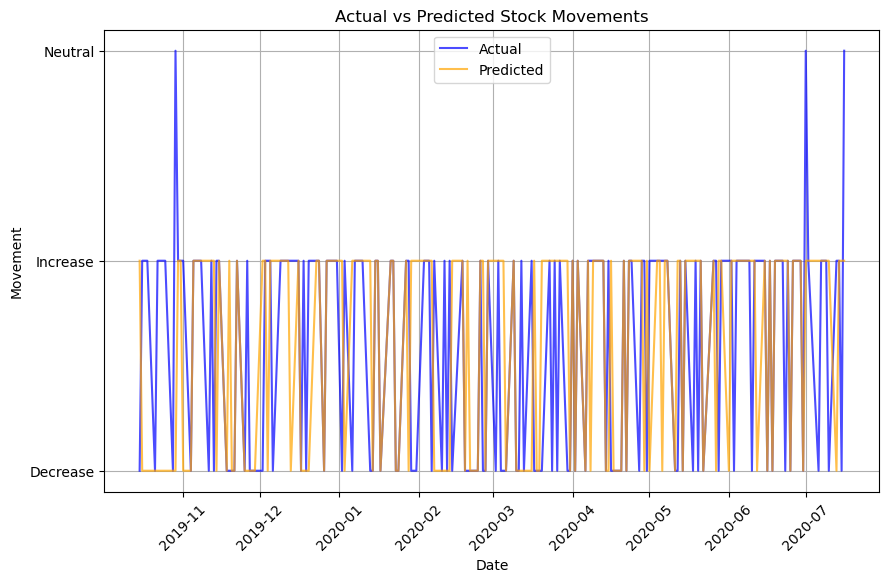

In [48]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot actual vs predicted class distributions
results_df = pd.DataFrame({
    'Actual': y_true,
    'Predicted': y_pred,
    'Date': test_data['Date'][sequence_length:]  
})

class_labels = {0: 'Neutral', 1: 'Increase', 2: 'Decrease'}
results_df['Actual'] = results_df['Actual'].map(class_labels)
results_df['Predicted'] = results_df['Predicted'].map(class_labels)

plt.figure(figsize=(10, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual', color='blue', alpha=0.7)
plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted', color='orange', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted Stock Movements')
plt.xlabel('Date')
plt.ylabel('Movement')
plt.xticks(rotation=45)
plt.grid()
plt.show()

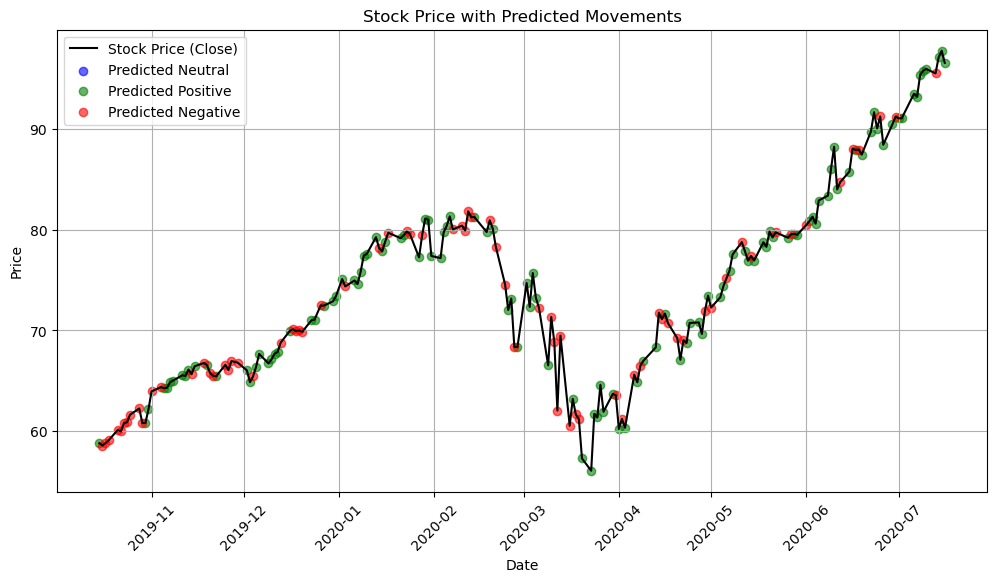

In [52]:
# Add the prediction to the stock data for visualization
aligned_test_data = test_data[sequence_length:].copy()
aligned_test_data['Predicted'] = y_pred

# Plot stock price and predictions
plt.figure(figsize=(12, 6))
plt.plot(aligned_test_data['Date'], aligned_test_data['Close'], label='Stock Price (Close)', color='black')

plt.scatter(aligned_test_data['Date'][aligned_test_data['Predicted'] == 0],
            aligned_test_data['Close'][aligned_test_data['Predicted'] == 0],
            color='blue', label='Predicted Neutral', alpha=0.6)
plt.scatter(aligned_test_data['Date'][aligned_test_data['Predicted'] == 1],
            aligned_test_data['Close'][aligned_test_data['Predicted'] == 1],
            color='green', label='Predicted Positive', alpha=0.6)
plt.scatter(aligned_test_data['Date'][aligned_test_data['Predicted'] == 2],
            aligned_test_data['Close'][aligned_test_data['Predicted'] == 2],
            color='red', label='Predicted Negative', alpha=0.6)

plt.legend()
plt.title('Stock Price with Predicted Movements')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid()
plt.show()